# Task

Implement a model using machine learning classifiers, which will determine whether the transaction is fraudulent or not.

Requirements: 
* Fraud precision > 90%
* Maximum Fraud recall

# Data loading and invistigation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs
from pandas.tools.plotting import parallel_coordinates
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix
from sklearn.metrics import f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [6]:
# Load all data to dataframe
frame = pd.read_excel('DatasetTask2SolidDataAnalyst.xlsx', sheet_name='Sheet1')

Fraud detection has the following properties:
* uncommon - fraud cases are in minority
* concealed - fraudsters try their best to "blend" in and cenceal their activities
* changing over time - fraudsters find new methods to avoid getting caught, and as such their behavior changes over time
* organized - fraudsters oftentimes work together and organize their activities in a network, making it harder to detect

In [7]:
# Get dataframe shape
frame.shape

(94579, 194)

Check the balance of data for both classes.

In [8]:
occ = frame['fraud'].value_counts()
occ/len(frame.index)

0    0.957263
1    0.042737
Name: fraud, dtype: float64

Split data to features and labels.

In [9]:
y = frame['fraud']
X = frame.loc[:, frame.columns != 'fraud']

Split data to train and test Sets.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Data resampling

Fraud cases are in minority. To manage class imbalance I will use SMOTE.
Synthetic Minority Oversampling Technique uses charecteristics of nearest neighbours of fraud cases to create new synthetic fraud cases, and therby avoids diplications observations.
Works good only if fraud cases are quite similar to each other.

In [11]:
from imblearn.over_sampling import SMOTE

In [12]:
method = SMOTE(kind='regular')
X_train, y_train = method.fit_sample(X_train, y_train)

Create function to visualize data.

In [13]:
def visualize_data(X, y):
    pca = sklearnPCA(n_components=2) #2-dimensional PCA
    transformed = pd.DataFrame(pca.fit_transform(X))
    plt.scatter(transformed[y==0][0], transformed[y==0][1], label='Normal', c='red')
    plt.scatter(transformed[y==1][0], transformed[y==1][1], label='Fraud', c='blue')

    plt.legend()
    plt.show()

Show data before resampling.

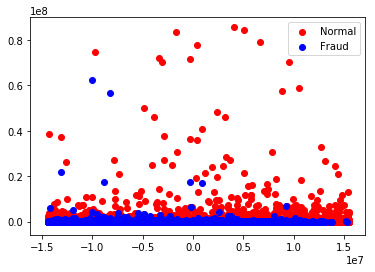

In [14]:
visualize_data(X, y)

Show data after resampling.

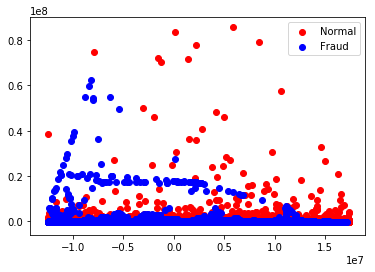

In [15]:
visualize_data(X_train, y_train)

# Predict Fraud

Create function that will run model and return results.

In [16]:
def run_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, pred)
    report = classification_report(y_test, pred)
    return matrix, report, pred

Create function that will Print Stats for model.

Fraud precision is the proportion of elements really belonging to this class relative to all documents that the system attributed to fraud.
The fraud recall is the proportion of elements found by the classifier of the class fraud belonging to all the documents of this class in the test sample.
In our case fraud is negative. So 

Precision = TN/(TN+FN)

Recall = TN/(TN+FP)

Let's also calculate Accuracy, Cohen Kappa, Recall and F1 for every model.

In [25]:
def print_stats(cmat, report, y_test, pred):
   # separate out the confusion matrix components
    tpos = cmat[0][0]
    fneg = cmat[0][1]
    fpos = cmat[1][0]
    tneg = cmat[1][1]
    # calculate F!, Recall scores
    f1Score = round(f1_score(y_test, pred), 2)
    recallScore = round(recall_score(y_test, pred), 2)
    # calculate and display metrics
    print(cmat)
    print(report)
    # calculate metrics for fraud data
    print('Fraud precision:' + str(np.round(100*float(tneg)/float(tneg+fneg), 2))+'%')
    print('Fraud recall:'+str(np.round(100*float(tneg)/float(tneg+fpos), 2))+'%')
    print( 'Accuracy: '+ str(np.round(100*float(tpos+fneg)/float(tpos+fneg + fpos + tneg),2))+'%')
    print( 'Cohen Kappa: '+ str(np.round(cohen_kappa_score(y_test, pred),3)))
    print("Sensitivity/Recall for Model : {recall_score}".format(recall_score = recallScore))
    print("F1 Score for Model : {f1_score}".format(f1_score = f1Score))

Use simple logistic regression to predict fraud.

In [18]:
# Fit a logistic regression model to the data
model = LogisticRegression(solver='lbfgs')
conf_matr, report, predicted = run_model(model, X_train, y_train, X_test, y_test)
# Print the classifcation report and confusion matrix
print_stats(conf_matr, report, y_test, predicted)

[[27073    62]
 [ 1234     5]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     27135
           1       0.07      0.00      0.01      1239

   micro avg       0.95      0.95      0.95     28374
   macro avg       0.52      0.50      0.49     28374
weighted avg       0.92      0.95      0.93     28374

Fraud precision:7.46%
Fraud recall:0.4%
Accuracy: 95.63%
Cohen Kappa: 0.003
Sensitivity/Recall for Model : 0.0
F1 Score for Model : 0.01


Logistic regression model has very low precision and recall. 
Logistic regression assumes that there is one smooth linear decision boundary.
Let's try Random Forest Classifier now.

In [19]:
model = RandomForestClassifier(random_state=6, class_weight='balanced', n_estimators=100)
conf_matr, report, predicted = run_model(model, X_train, y_train, X_test, y_test)
# Print the classifcation report and confusion matrix
print_stats(conf_matr, report, y_test, predicted)

[[27087    48]
 [  818   421]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     27135
           1       0.90      0.34      0.49      1239

   micro avg       0.97      0.97      0.97     28374
   macro avg       0.93      0.67      0.74     28374
weighted avg       0.97      0.97      0.96     28374

Fraud precision:89.77%
Fraud recall:33.98%
Accuracy: 95.63%
Cohen Kappa: 0.481
Sensitivity/Recall for Model : 0.34
F1 Score for Model : 0.49


Random Forest Classifier performs much better. Precision is close to requirements.

Let's try XGBCLassifier with different parameters to predict labels.
Use not resampled data for this classifier.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model1 = XGBClassifier(max_depth = 10, n_jobs = 4, subsample=0.7 )
# Get the results 
conf_matr, report, predicted = run_model(model1, X_train, y_train, X_test, y_test)
# Print the classifcation report and confusion matrix
print_stats(conf_matr, report, y_test, predicted)

[[27085    92]
 [  660   537]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27177
           1       0.85      0.45      0.59      1197

   micro avg       0.97      0.97      0.97     28374
   macro avg       0.91      0.72      0.79     28374
weighted avg       0.97      0.97      0.97     28374

Fraud precision:85.37%
Fraud recall:44.86%
Accuracy: 95.78%
Cohen Kappa: 0.576
Sensitivity/Recall for Model : 0.45
F1 Score for Model : 0.59


In [41]:
model2 = XGBClassifier(max_depth=8, eta=10**-1, silent=1, min_child_weight=3, subsample= 0.7 ,early_stopping_rounds=10, objective="count:poisson",colsample_bytree=0.65)

conf_matr, report, predicted = run_model(model2, X_train, y_train, X_test, y_test)
# Print the classifcation report and confusion matrix
print_stats(conf_matr, report, y_test, predicted)

[[27118    59]
 [  791   406]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     27177
           1       0.87      0.34      0.49      1197

   micro avg       0.97      0.97      0.97     28374
   macro avg       0.92      0.67      0.74     28374
weighted avg       0.97      0.97      0.96     28374

Fraud precision:87.31%
Fraud recall:33.92%
Accuracy: 95.78%
Cohen Kappa: 0.476
Sensitivity/Recall for Model : 0.34
F1 Score for Model : 0.49


First model showed better result. XGBoost gives precision close to requirement and high recall.

Let's get importance parameters from this model for top 30 features and show their importance on the chart.

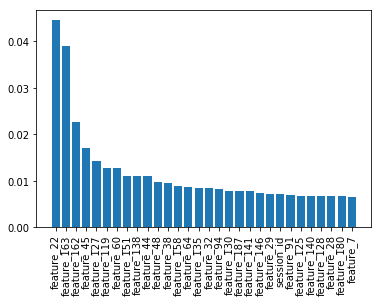

In [22]:
from matplotlib import pyplot

features = X.columns.to_frame().reset_index(drop=True)
features['importance'] = model1.feature_importances_
features.columns = ['name', 'importance']
main_features = features.sort_values(by=['importance'], ascending=False).head(30)
pyplot.bar(range(len(main_features)), main_features.importance)
x_pos = np.arange(len(main_features))
pyplot.xticks(x_pos, main_features.name, rotation='vertical')
pyplot.show()

As we see XBGClassifier and Random Forest Classifier give the best result. Let's use ensemle of multiple methods to improve predictive model.

My empirical tests have shown that the best results are obtained by combining three machine learning methods - XGBClassifier, RandomForestClassifier and DecisionTreeClassifier.

In [29]:

# Define the three classifiers to use in the ensemble
clf1 = XGBClassifier(max_depth = 9, n_jobs = 4)
clf2 = RandomForestClassifier(criterion='gini', max_depth=4, max_features='auto', n_estimators=30)
clf3 = DecisionTreeClassifier(class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard', weights=[4, 4, 2], flatten_transform=True)
conf_matr, report, predicted = run_model(ensemble_model, X_train, y_train, X_test, y_test)
# Print the classifcation report and confusion matrix
print_stats(conf_matr, report, y_test, predicted)

[[27096    39]
 [  819   420]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     27135
           1       0.92      0.34      0.49      1239

   micro avg       0.97      0.97      0.97     28374
   macro avg       0.94      0.67      0.74     28374
weighted avg       0.97      0.97      0.96     28374

Fraud precision:91.5%
Fraud recall:33.9%
Accuracy: 95.63%
Cohen Kappa: 0.482
Sensitivity/Recall for Model : 0.34
F1 Score for Model : 0.49


Precision meets the desired level. However, recall has decreased.

Method predict_proba() will give the likelihood of fraud for scoring cards.

In [38]:
pred = model.predict_proba(X_test)

# Results

During the study, it was found that the best results give RandomForestClassifier and XGClassifier. 
Voting classifier with XGBoost, RandomForest and DecisionTree gave the best result by precision on not resampled data.
Opportunities for improvement: use GridSearchCV to find the most effective parameters for each classifier.